In [1]:
import os
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from open_clip import create_model
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import LabelEncoder, StandardScaler
os.chdir('..')

/home/raffaele/art/contrastive-artwork-classification/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from src.experiment import CLIPGraphRun
from src.data import ImageDataset
from src.utils import load_ruamel
from src.data import DataDict

In [3]:
num_sampled_artworks = 500
num_neighbors =20
random_state = 42
save=True

In [4]:
test_set = pd.read_csv('./data/processed/normal/artgraph_clip_style/test.csv')
test_set

,artwork,style
0,konstantin-korovin_morning-1914.jpg,impressionism
1,jimmy-ernst_synapse-1950.jpg,abstract expressionism
2,nicholas-roerich_lahaul-himalayas-1932.jpg,symbolism
3,vilho-lampi_self-portrait-1931.jpg,expressionism
4,william-holman-hunt_may-morning-on-magdalen-co...,romanticism
...,...,...
11642,claude-monet_the-manneport.jpg,impressionism
11643,george-romney_miss-martindale-1782.jpg,rococo
11644,jacques-louis-david_portrait-of-madame-charles...,neoclassicism
11645,giovanni-bellini_pesaro-altarpiece-1474-2.jpg,early renaissance


In [5]:
mapping_style = {
    "art nouveau (modern)": "art nouveau",
    "naïve art (primitivism)": "naïve art",
    "mannerism (late renaissance)": "late renaissance",
}

In [6]:
test_set["style"] = test_set["style"].map(lambda x: mapping_style.get(x, x))
test_set["style"].unique().tolist()

['impressionism',
 'abstract expressionism',
 'symbolism',
 'expressionism',
 'romanticism',
 'academicism',
 'baroque',
 'early renaissance',
 'post-impressionism',
 'surrealism',
 'art nouveau',
 'realism',
 'cubism',
 'northern renaissance',
 'rococo',
 'art deco',
 'minimalism',
 'neo-romanticism',
 'ukiyo-e',
 'fauvism',
 'naïve art',
 'pop art',
 'art informel',
 'magic realism',
 'late renaissance',
 'abstract art',
 'lyrical abstraction',
 'neoclassicism',
 'color field painting',
 'contemporary realism',
 'high renaissance',
 'neo-expressionism']

In [7]:
drop, sampled_test_set = train_test_split(
    test_set,
    test_size=num_sampled_artworks,
    stratify=test_set["style"],
    random_state=42,
)
sampled_test_set

,artwork,style
3483,alex-colville_embarkation-1994.jpg,contemporary realism
3209,louis-marcoussis_breton-bread-two-fish-spoon-1...,cubism
6442,pablo-picasso_portrait-of-aunt-pepa-1896.jpg,realism
9976,isaac-levitan_mediterranean-seacoast-1890.jpg,realism
11477,frans-hals_dorothea-berck-1644.jpg,baroque
...,...,...
8636,jean-francois-millet_the-carder.jpg,realism
3307,georges-papazoff_composition-1929.jpg,surrealism
8292,antonio-jacobsen_rounding-the-mark-nycc-regatt...,realism
6889,ivan-shishkin_forest-1897.jpg,realism


In [8]:
parameters = load_ruamel(
    "./configs_cineca/proposed_model/style/normal_clip_graph_sage3.yaml"
)
parameters["clean_out_dir"] = False
parameters["model"]["gnn"]["params"]["dropout"] = 0.0
run = CLIPGraphRun(parameters=parameters)
run.load_state_dict()

Loading general parameters...
Done!
Loading dataloaders...
Done!
Loading model...
Done!
Loading metrics...
Done!
Loading tokenizer...
Done!
Loading criterion...
Done!
Loading optimizer...
Done!
Loading scheduler...
Done!
Loading early stop callback...
Done!
loading state dict from models/proposed/style/normal_clip_graph_gcn3/ParameterKeys.MODEL.pt


In [9]:
visual = run.model.visual
visual

VisionTransformer(
  (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
  (patch_dropout): Identity()
  (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (transformer): Transformer(
    (resblocks): ModuleList(
      (0-11): 12 x ResidualAttentionBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (ls_1): Identity()
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
        (ls_2): Identity()
      )
    )
  )
  (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [10]:
sampled_image_test_dataset = ImageDataset(
    dataset=sampled_test_set,
    img_dir=run.test_loader.dataset.img_dir,
    preprocess=run.test_loader.dataset.preprocess,
)
batch_size = 64
sampled_dataloader = DataLoader(
    dataset=sampled_image_test_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
)

In [11]:
out_features = torch.empty(size=(len(sampled_image_test_dataset), 512))
out_features.size()

torch.Size([500, 512])

In [12]:
clip_model = create_model(**parameters["model"]["visual"]).visual.to("cuda")
clip_features = torch.zeros_like(out_features)

In [13]:
with torch.no_grad():
    for ix, (data_dict) in tqdm(
        enumerate(sampled_dataloader), total=len(sampled_dataloader)
    ):
        img_tensors = data_dict[DataDict.IMAGE].to("cuda")
        img_feats = visual(img_tensors)
        img_clip_feats = clip_model(img_tensors)
        start_idx = ix * batch_size
        end_idx = min((ix + 1) * batch_size, out_features.size(0))
        out_features[start_idx:end_idx] = img_feats.cpu()
        clip_features[start_idx:end_idx] = img_clip_feats.cpu()

out_features = out_features.numpy()
clip_features = clip_features.numpy()

100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


In [14]:
custom_palette = [
    "#1F77B4",
    "#AEC7E8",
    "#FF7F0E",
    "#FFBB78",
    "#2CA02C",
    "#98DF8A",
    "#D62728",
    "#FF9896",
    "#9467BD",
    "#C5B0D5",
    "#8C564B",
    "#C49C94",
    "#E377C2",
    "#F7B6D2",
    "#7F7F7F",
    "#C7C7C7",
    "#BCBD22",
    "#DBDB8D",
]
len(custom_palette)

18

# TNSE

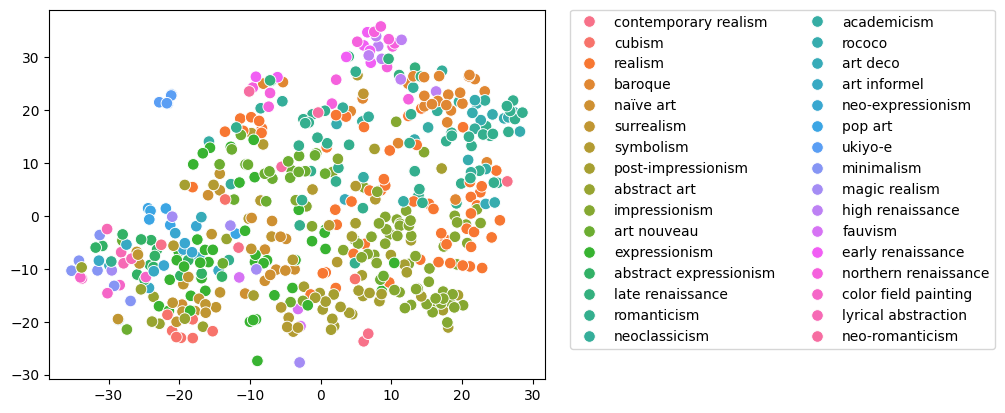

In [15]:
n_components = 2
tsne = TSNE(
    n_components=n_components, perplexity=num_neighbors, random_state=random_state
)
tsne_result = tsne.fit_transform(StandardScaler().fit_transform(out_features))
tsne_result_df = pd.DataFrame(
    {
        "tsne_1": tsne_result[:, 0],
        "tsne_2": tsne_result[:, 1],
        "label": sampled_test_set["style"].values,
    }
)
fig, ax = plt.subplots(1)
sns.scatterplot(x="tsne_1", y="tsne_2", hue="label", data=tsne_result_df, ax=ax, s=70)
lim = (tsne_result.min() - 5, tsne_result.max() + 5)
ax.set(xlabel=None, ylabel=None)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
fig.savefig('./reports/figures/graph_clip_tsne_style_col1.png', dpi=500, bbox_inches="tight")

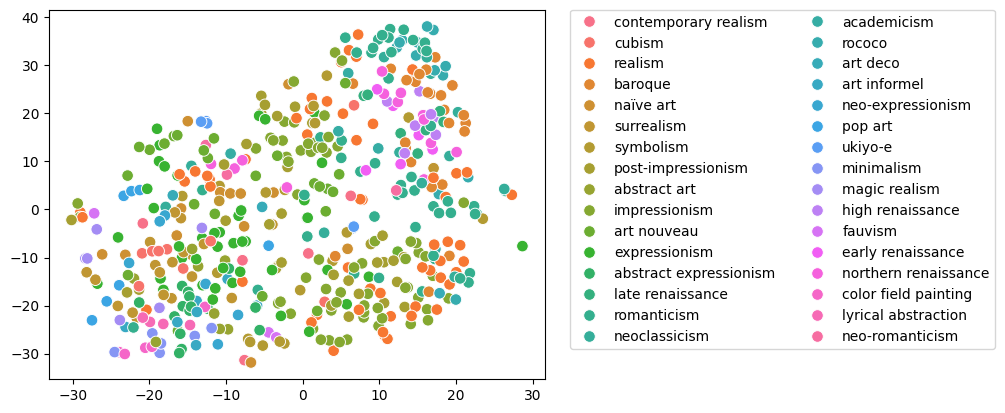

In [16]:
n_components = 2
tsne = TSNE(
    n_components=n_components, perplexity=num_neighbors, random_state=random_state
)
tsne_result = tsne.fit_transform(StandardScaler().fit_transform(clip_features))
tsne_result_df = pd.DataFrame(
    {
        "tsne_1": tsne_result[:, 0],
        "tsne_2": tsne_result[:, 1],
        "label": sampled_test_set["style"].values,
    }
)
fig, ax = plt.subplots(1)
sns.scatterplot(x="tsne_1", y="tsne_2", hue="label", data=tsne_result_df, ax=ax, s=70)
lim = (tsne_result.min() - 5, tsne_result.max() + 5)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, ncol=2)
ax.set(xlabel=None, ylabel=None)
fig.savefig('./reports/figures/clip_tsne_style.png', dpi=500, bbox_inches="tight")